# 01 声音是如何产生的

声音以波的形式传播，即声波（Sound Wave）。当我们以波的视角来理解声音时，却又大繁若简起来：仅凭频率（Frequency）、
幅度（Magnitude）、相位（Phase）便构成了波及其叠加的所有，声音的不同音高（Pitch）、音量（Loudness）、音色（Timbre）
也由这些基本“粒子”组合而来。

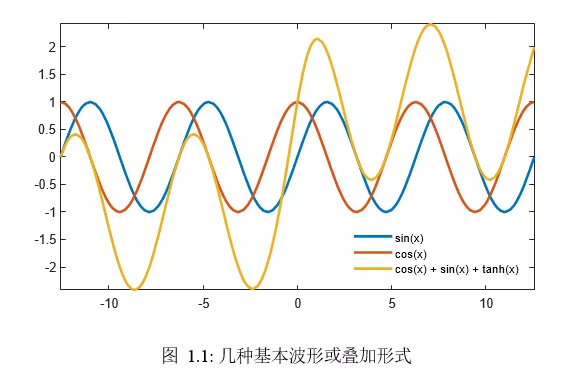

世上形形色色的声波都可以“降解”到基本波身上，这也是傅里叶变换（Fourier Transform）的基本思想。
不同的声波有不同的频率和幅度（决定音量），人耳也有自己的接受范围。人耳对频率的接受范围大致为 20 Hz至20 kHz，
于是以人为本地将更高频率的声波定义为超声波（Ultrasound Wave）、更低频率的声波定义为次声波（Infrasound Wave），
虽然其他动物可以听到不同范围的声音；人耳对音量的接受范围已经进化得适应了地球上的常规声音，小到呼吸声、飞虫声， 大到飞机起飞、
火箭发射的声音（已经不是地球默认配置），再往上，人的身心就越来越承受不住了，为了衡量音量的大小，再一次以人为本地将人耳所能听到
的1kHz纯音的音量下限定义为0dB。

# 02 赛题数据集介绍

声音分类在很多场景中都有大模型的应用，例如对音乐的分类可以应用于音乐检索和音乐推荐中；
对人声的分类可以应用在身份识别、智能家居中。本比赛的背景是食物的声音的分类，是一个充满趣味性的任务。

本次比赛的数据集来自Kaggle的“Eating Sound Collection”（可商用），
数据集中包含20种不同食物的咀嚼声音，赛题任务是给这些声音数据建模，准确分类。


In [52]:
### 下载天池数据集并解压
!wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531887/train_sample.zip
!unzip -qq train_sample.zip
!\rm train_sample.zip

!wget http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531887/test_a.zip
!unzip -qq test_a.zip
!\rm test_a.zip

--2021-04-10 22:43:16--  http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531887/train_sample.zip
Resolving tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)... 118.31.232.194
Connecting to tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)|118.31.232.194|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 540689175 (516M) [application/zip]
Saving to: ‘train_sample.zip’

100%[======================================>] 540,689,175 12.7MB/s   in 41s    

2021-04-10 22:43:58 (12.4 MB/s) - ‘train_sample.zip’ saved [540689175/540689175]

--2021-04-10 22:44:44--  http://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531887/test_a.zip
Resolving tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)... 118.31.232.194
Connecting to tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.

# 03 数据探索

### 3.1 加载库

In [42]:
# 基本库

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

In [43]:
# 加载音频处理库
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import glob
import IPython.display as ipd

Python有一些很棒的音频处理库，比如Librosa和PyAudio，还有一些内置的模块用于处理音频的基本处理。

我们将主要使用两个库进行音频采集和回放：
1）Librosa：它通常用于分析音频信号，但更倾向于音乐，它包括用于构建MIR（音乐信息检索）系统的nuts 和 bolts。示例和教程可以参考：https://librosa.github.io/librosa/
2）IPython.display.Audio： 该模块能使得音频直接在jupyter笔记本中播放。

这两个库我们下面都会用到，可用以下命令进行安装：pip install 【包名，如“librosa”】 -i http://pypi.douban.com/simple/ --trusted-host pypi.douban.com

### 3.2 查看音频数据

In [44]:
voice_path = './train_sample'


def look_data():
    # 音频类别文件夹个数
    print(f'音频文件夹的个数: {len(os.listdir(voice_path))}')

    voice_total = 0
    single_label = {}
    for ind, label_name in enumerate(os.listdir(voice_path)):
        file_path = voice_path + '/' + label_name
        single_num = len(os.listdir(file_path))
        single_label[label_name] = single_num
        voice_total += single_num

    print(f'音频文件总量： {voice_total}')
    print(f'{"序号":<5}{"类别":<15}{"数量":<10}{"占比"}')
    for ind, (key, value) in enumerate(single_label.items()):
        print(f'{ind:<5}{key:<20}{value:<10}{value / voice_total:.2%}')


look_data()

音频文件夹的个数: 20
音频文件总量： 1000
序号   类别             数量        占比
0    aloe                45        4.50%
1    burger              64        6.40%
2    cabbage             48        4.80%
3    candied_fruits      74        7.40%
4    carrots             49        4.90%
5    chips               57        5.70%
6    chocolate           27        2.70%
7    drinks              27        2.70%
8    fries               57        5.70%
9    grapes              61        6.10%
10   gummies             65        6.50%
11   ice-cream           69        6.90%
12   jelly               43        4.30%
13   noodles             33        3.30%
14   pickles             75        7.50%
15   pizza               55        5.50%
16   ribs                47        4.70%
17   salmon              37        3.70%
18   soup                32        3.20%
19   wings               35        3.50%


食物的音频主要有6.26G的内存，总共20种食物，总共11140个声音。

### 3.3 查看音频特征

以两个音频为例

In [45]:

# 播放芦荟的声音
ipd.Audio('./train_sample/aloe/24EJ22XBZ5.wav')

In [46]:
# 播放汉堡的声音
ipd.Audio('./train_sample/burger/0WF1KDZVPZ.wav')

使用librosa模块加载音频文件，librosa.load()加载的音频文件，默认采样率（sr）为22050HZ mono。我们可以通过librosa.load(path,sr=44100)来更改采样频率

In [47]:
data1, sampling_rate1 = librosa.load('./train_sample/aloe/24EJ22XBZ5.wav')
data2, sampling_rate2 = librosa.load('./train_sample/burger/0WF1KDZVPZ.wav')

查看波形幅度包络图

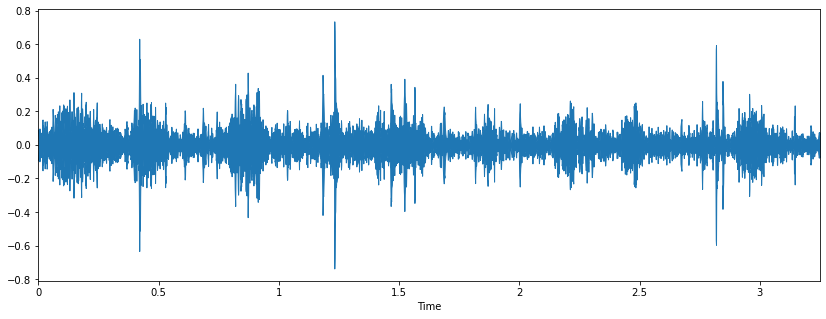

In [48]:
# 芦荟的波形幅度包络
plt.figure(figsize=(14, 5))
librosa.display.waveplot(data1,sr=sampling_rate1)


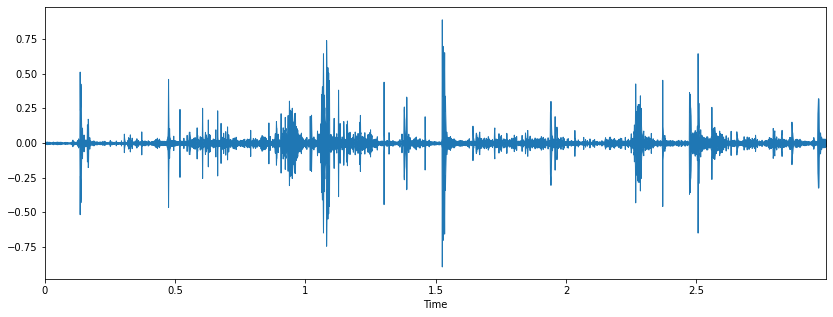

In [49]:
# 汉堡的波形幅度包络图
plt.figure(figsize=(14, 5))
librosa.display.waveplot(data2,sr=sampling_rate2)

查看声谱图

声谱图（spectrogram）是声音或其他信号的频率随时间变化时的频谱（spectrum）的一种直观表示。声谱图有时也称sonographs,voiceprints,或者voicegrams。当数据以三维图形表示时，可称其为瀑布图（waterfalls）。在二维数组中，第一个轴是频率，第二个轴是时间。我们使用librosa.display.specshow来显示声谱图。

Text(0.5, 1.0, 'Linear-frequency power spectrogram of aloe')

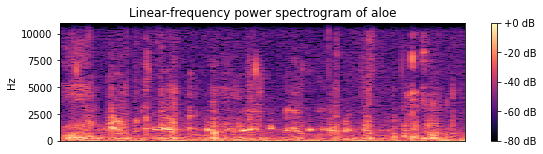

In [50]:
# 芦荟的声谱图
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram of aloe')

Text(0.5, 1.0, 'Linear-frequency power spectrogram of burger')

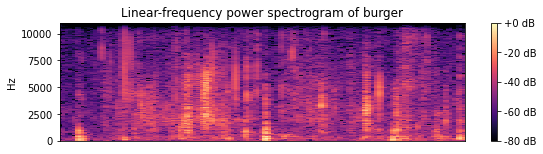

In [51]:
# 汉堡的声图谱
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram of burger')